<a href="https://colab.research.google.com/github/bennettJG/data17200project/blob/main/Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
# Load preprocessed data from part 1

import zipfile, io, pickle
from urllib.request import urlopen

# Suppress non-convergence warnings from LogisticRegression for readability
import warnings
warnings.filterwarnings("ignore")

r = urlopen("https://github.com/bennettJG/data17200project/raw/refs/heads/main/preprocessed_data.zip")
#print(r)
z = zipfile.ZipFile(io.BytesIO(r.read()))
z.extractall()

with open("preprocessed_data.pkl", "rb") as input_file:
  X_train_scaled, X_test_scaled, y_train, y_test = pickle.load(input_file)

groups_train = X_train_scaled['patient_nbr']
groups_traintest = pd.concat([X_train_scaled, X_test_scaled])['patient_nbr']
X_train_scaled = X_train_scaled.drop('patient_nbr', axis=1)
X_test_scaled = X_test_scaled.drop('patient_nbr', axis=1)

In [89]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedGroupKFold, StratifiedShuffleSplit, GridSearchCV, cross_val_score, cross_validate, validation_curve
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

random_state=1701

In [107]:
from sklearn.metrics import make_scorer

# Helper functions for displaying cross-validation and test metrics, so I don't have to copy-paste code for each model

def calculate_cv_metrics(model, X, y, pos_label, groups):
  # Need StratifiedGroupKFold to make sure different visits for the same patient end up in either the training or validation set each time (group) and
  # balance on target class proportions (stratify)
  kfold = StratifiedGroupKFold(n_splits = 5, random_state = random_state, shuffle=True)
  # Need to make sure we are looking at the group we care about (pos_label will be either True in the binary case or "<30" in the multiclass case_
  # The built-in weighting methods in scikit-learn don't allow less common classes to be weighted higher so we do have to customize the scorer here to
  # have it just focus on the class we want to optimize for.
  cv_score = cross_validate(model, X, y, groups = groups, cv=kfold, scoring = {'acc': make_scorer(accuracy_score),
                                                              'prec': make_scorer(precision_score, average=None, labels=[pos_label], pos_label=pos_label),
                                                              'rec': make_scorer(recall_score, average=None, labels=[pos_label], pos_label=pos_label),
                                                              'fone': make_scorer(f1_score, average=None, labels=[pos_label], pos_label=pos_label)})
  results = {'Avg accuracy': np.mean(cv_score['test_acc']).round(4),
             'Avg precision': np.mean(cv_score['test_prec']).round(4),
             'Avg recall': np.mean(cv_score['test_rec']).round(4),
             'Avg F1 score':np.mean(cv_score['test_fone']).round(4)}
  for score, val in results.items():
    print(f'{score}: {val}\n')
  return cv_score

def grid_recall(model, X, y, pos, param_grid, groups):
  kfold = StratifiedGroupKFold(n_splits = 3, random_state = random_state, shuffle=True)
  grid = GridSearchCV(model, cv=kfold, scoring = make_scorer(recall_score, average=None, labels=[pos], pos_label=pos), param_grid=param_grid, error_score='raise', verbose=0)
  grid.fit(X, y, groups = groups)
  print(f"The best parameters are {grid.best_params_} with a recall of {grid.best_score_:.4f} for readmission within 30 days.")
  return grid

def calculate_test_metrics(model, X_train_scaled, X_test_scaled, y_train, y_test):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    # Accuracy, precision, recall, etc.
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f'Classification report:\n')
    print(classification_report(y_test, y_pred))
    # Confusion matrix -- more helpful for assessing false positive/false negative rates at a glance
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Target Value Distribution

The target values are highly unbalanced, particularly for the value we care most about (readmission within 30 days).

<Axes: xlabel='readmit_less30'>

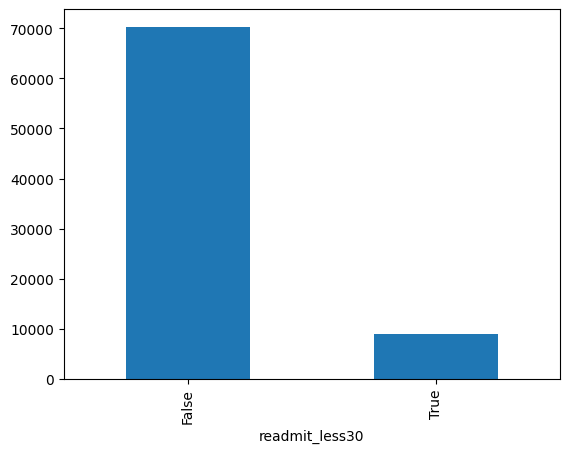

In [18]:
y_train['readmit_less30'].value_counts().plot.bar(x='readmit_less30')

<Axes: xlabel='readmitted'>

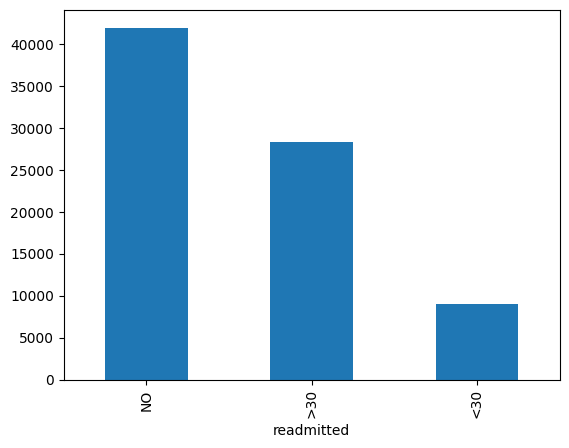

In [19]:
y_train['readmitted'].value_counts().plot.bar(x='readmitted')

# Model fitting

Given how unbalanced the target values are, I'd prefer to use models that can take the `class_weight='balanced'` parameter, which weights observations based on the rarity of the target value. This improves predictions for less common target classes, and in this particular case the class we care most about -- readmission within 30 days -- is very uncommon. Without accounting for the imbalance, many models will simply assign most/all observations to the more common class, resulting in a very high accuracy but very low recall in the case we most care about.

Models which work with `class_weight='balanced'` include logistic regression, decision trees, random forests, and support vector machines (SVM). I chose to use **logistic regression and random forest** models. I initially attempted to fit an SVM (with the default RBF kernel) as well, but it was impractically slow on my low-powered home computer (the base model, without cross-validation, had still not finished training after nearly an hour).

For each model, I began by testing both multi-class and binary classification, to see whether attempting to additionally predict readmission in more than 30 days detracted from the quality of predictions for the most important outcome of readmission within 30 days.

## With default hyperparameters
### Multi-class

Classification report:

              precision    recall  f1-score   support

         <30       0.22      0.69      0.33      2298
         >30       0.63      0.12      0.20      7175
          NO       0.77      0.82      0.79     10929

    accuracy                           0.56     20402
   macro avg       0.54      0.54      0.44     20402
weighted avg       0.66      0.56      0.53     20402



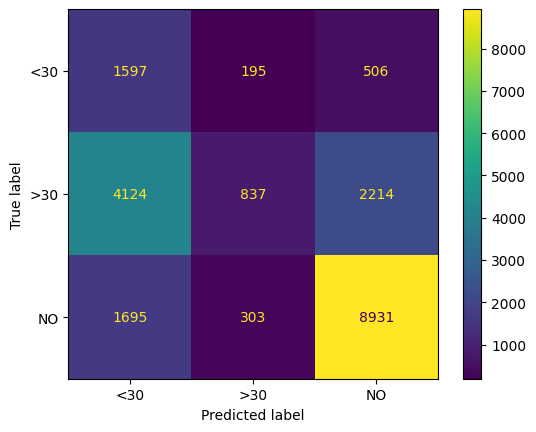

In [108]:
logistic_multiclass = LogisticRegression(random_state=random_state, class_weight='balanced')

calculate_test_metrics(logistic_multiclass, X_train_scaled, X_test_scaled, y_train['readmitted'], y_test['readmitted'])

Classification report:

              precision    recall  f1-score   support

         <30       0.45      0.01      0.02      2298
         >30       0.65      0.62      0.63      7175
          NO       0.75      0.92      0.83     10929

    accuracy                           0.71     20402
   macro avg       0.62      0.52      0.49     20402
weighted avg       0.68      0.71      0.67     20402



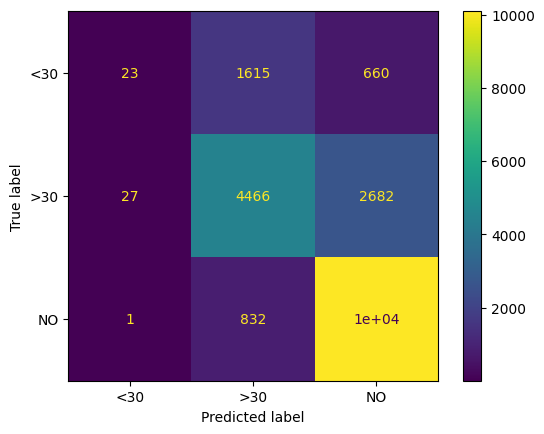

In [22]:
rf_multiclass = RandomForestClassifier(random_state=random_state, class_weight='balanced')
calculate_test_metrics(rf_multiclass, X_train_scaled, X_test_scaled, y_train['readmitted'], y_test['readmitted'])

Here, the random forest model performs very poorly on the test set, predicting very few readmissions within 30 days regardless of the true label. This is likely a result of overfitting the test data.

The overall accuracy for the logistic regression model is lower, but it performs significantly better than RF in predicting readmission within 30 days. However, the recall for this category is still not ideal at 0.69, and recall for admission after 30 days or more is extremely low. This model also does worse in predicting the "no readmission" category (that is, there is a high rate of false-positive readmission predictions).

### Binary classification

Classification report:

              precision    recall  f1-score   support

       False       0.95      0.59      0.73     18104
        True       0.19      0.77      0.31      2298

    accuracy                           0.61     20402
   macro avg       0.57      0.68      0.52     20402
weighted avg       0.87      0.61      0.68     20402



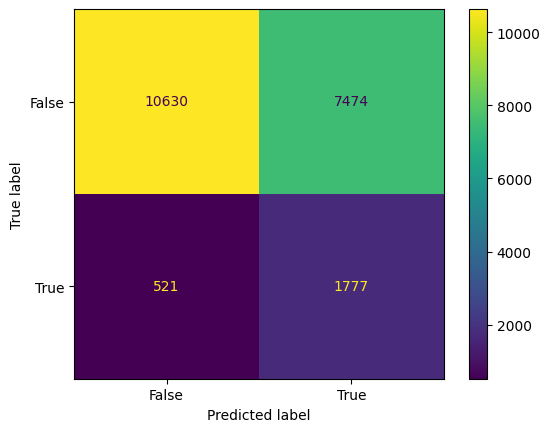

In [23]:
logistic_binary = LogisticRegression(random_state=random_state, class_weight='balanced')
calculate_test_metrics(logistic_binary, X_train_scaled, X_test_scaled, y_train['readmit_less30'], y_test['readmit_less30'])

Classification report:

              precision    recall  f1-score   support

       False       0.89      1.00      0.94     18104
        True       0.27      0.00      0.00      2298

    accuracy                           0.89     20402
   macro avg       0.58      0.50      0.47     20402
weighted avg       0.82      0.89      0.83     20402



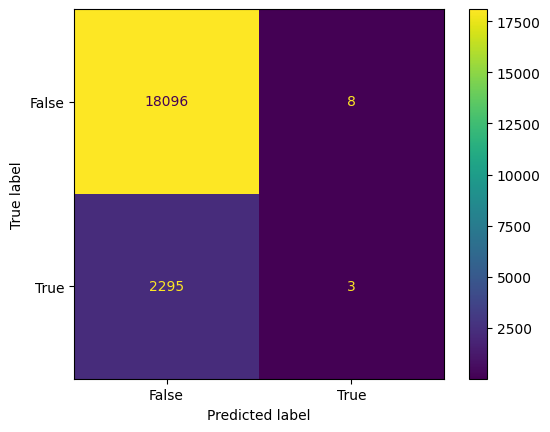

In [71]:
rf_binary = RandomForestClassifier(random_state=random_state, class_weight='balanced_subsample')
calculate_test_metrics(rf_binary, X_train_scaled, X_test_scaled, y_train['readmit_less30'], y_test['readmit_less30'])

The random forest model performs even worse on the binary classification task under default settings, with a recall score of only 1% (!!) on the rare class we care most about. Logistic regression achieves 77% recall for readmission within 30 days, which is better than the 69% obtained in multiclass classification, and considerably better than the ~10% obtainable by chance. However, it is still much lower than would be desirable for an algorithm to be used in a clinical context, and the false positive rate (around a third of patients not readmitted within 30 days are flagged as likely to be) also leaves much to be desired.

## Cross-validation on full dataset

The base options for cross-validation precision, recall, and accuracy scoring assume either that all classes are equally important to classify correctly (`micro`, `macro`) or that classes with more support should be weighted more heavily (`weighted`). Because we care primarily about the rarest class, this is specified using `make_scorer` when defining the `calculate_cv_metrics` function above.

In [109]:
calculate_cv_metrics(logistic_multiclass, pd.concat([X_train_scaled, X_test_scaled]), pd.concat([y_train['readmitted'], y_test['readmitted']]), pos_label = "<30", groups=groups_traintest);

Avg accuracy: 0.631

Avg precision: 0.2497

Avg recall: 0.4302

Avg F1 score: 0.3159



In [110]:
calculate_cv_metrics(rf_multiclass, pd.concat([X_train_scaled, X_test_scaled]), pd.concat([y_train['readmitted'], y_test['readmitted']]), pos_label = "<30", groups=groups_traintest);

Avg accuracy: 0.7179

Avg precision: 0.3891

Avg recall: 0.0146

Avg F1 score: 0.0282



In [111]:
calculate_cv_metrics(logistic_binary, pd.concat([X_train_scaled, X_test_scaled]), pd.concat([y_train['readmit_less30'], y_test['readmit_less30']]), pos_label = True, groups=groups_traintest);

Avg accuracy: 0.7242

Avg precision: 0.228

Avg recall: 0.5995

Avg F1 score: 0.3303



In [112]:
calculate_cv_metrics(rf_binary, pd.concat([X_train_scaled, X_test_scaled]), pd.concat([y_train['readmit_less30'], y_test['readmit_less30']]), pos_label = True, groups=groups_traintest);

Avg accuracy: 0.8865

Avg precision: 0.443

Avg recall: 0.0023

Avg F1 score: 0.0046



As with the single train-test run, we see in cross-validation that using default settings, logistic regression significantly outperforms random forest for correctly predicting readmission in under 30 days (recall score), suggesting overfitting issues with the RF model. While logistic regression outperforms chance given the class imbalance, it nonetheless leaves much to be desired. Oddly, the recall in cross-validation for the class we are most interested in is a good deal lower than when fitting on the train dataset -- perhaps we got lucky with our initial train-test split.

# Hyperparameter Tuning

Because cross-validation takes a long time to run and grid search involves trying a large number of combinations while cross-validating each, I reduced the number of CV folds to 3 for this step. While this may be less reliable, it was necessary with the limited hardware resources (and time) available for model fitting.

Also in the interest of efficiency, I chose to focus on hyperparameter tuning for the binary classification task, as performance in initial testing was better than the multiclass classification, and detecting readmission within 30 days is clinically most relevant.

For logistic regression, the only parameters which can be tuned are the regularization parameter C and (if using the `elasticnet` penalty option) l1_ratio, which corresponds to using an L1 penalty when set to 1, an L2 penalty when set to 0, and a mixture of both for intermediate values.

**WARNING!** These cells take a long time to run. The mean scores across CV folds are displayed in a heatmap below, so re-rerunning the calculations should hopefully not be necessary.

In [113]:
grid_logistic_bin = grid_recall(LogisticRegression(solver='saga', penalty='elasticnet', class_weight='balanced'),
                                X_train_scaled, y_train['readmit_less30'], groups = groups_train,
                                pos=True, param_grid={'C': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0, 0.25, 0.5, 0.75, 1]})

The best parameters are {'C': 1, 'l1_ratio': 0} with a recall of 0.6036 for readmission within 30 days.


<Axes: xlabel='param_l1_ratio', ylabel='param_C'>

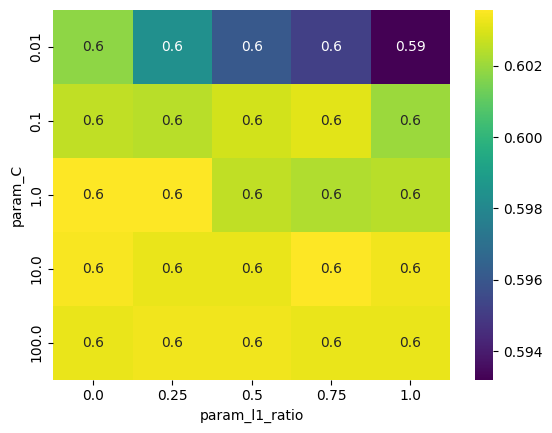

In [114]:
results = pd.DataFrame(grid_logistic_bin.cv_results_)
sns.heatmap(results.pivot(index="param_C", columns="param_l1_ratio", values="mean_test_score"), annot=True, cmap="viridis")

In [115]:
grid_rf_bin = grid_recall(RandomForestClassifier(random_state=random_state, class_weight='balanced_subsample', oob_score=recall_score),
                          X_train_scaled, y_train['readmit_less30'], pos=True, groups=groups_train,
                          param_grid={'n_estimators':[25, 50, 100, 200], 'max_depth':[5, 6, 7, 8, 9]})

The best parameters are {'max_depth': 6, 'n_estimators': 50} with a recall of 0.7872 for readmission within 30 days.


<Axes: xlabel='param_max_depth', ylabel='param_n_estimators'>

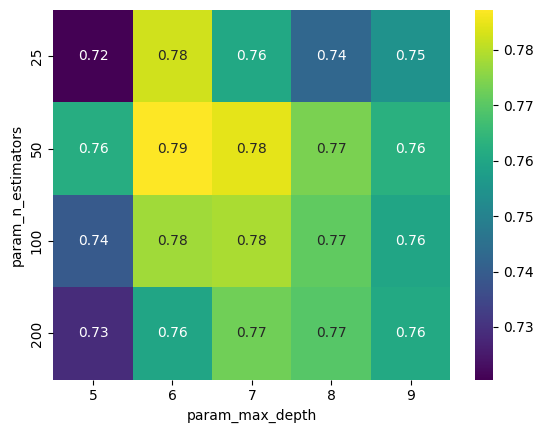

In [116]:
results = pd.DataFrame(grid_rf_bin.cv_results_)
sns.heatmap(results.pivot(index="param_n_estimators", columns="param_max_depth", values="mean_test_score"), annot=True, cmap="viridis")

We can now use the hyperparameters identified through grid search to fit a model on the full training set and test on the test set:

Classification report:

              precision    recall  f1-score   support

       False       0.96      0.59      0.73     18104
        True       0.20      0.80      0.32      2298

    accuracy                           0.61     20402
   macro avg       0.58      0.69      0.52     20402
weighted avg       0.87      0.61      0.68     20402



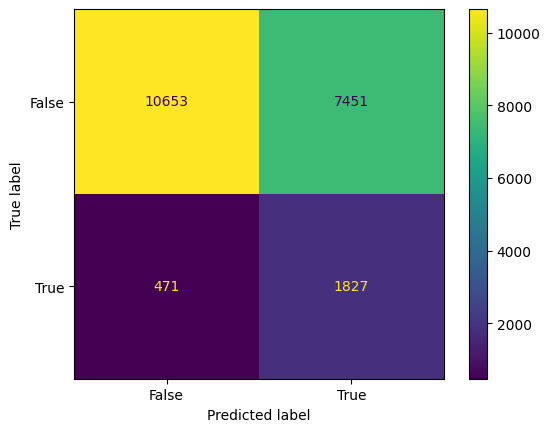

In [117]:
rf_binary_tuned = RandomForestClassifier(random_state=random_state, class_weight='balanced_subsample', max_depth=6, n_estimators=50)
calculate_test_metrics(rf_binary_tuned, X_train_scaled, X_test_scaled, y_train['readmit_less30'], y_test['readmit_less30'])

This is indeed more effective in correctly predicting the class of interest (readmission within 30 days), with a recall of 80% for this class compared to 77% for the better-fitting model (logistic regression) under default parameters, and FAR better than the default random forest performance. However, the false-positive rate is identical to the previous best model (recall of only 59% for the negative class, or a false-positive rate of around 40%). This is likely not sufficient performance to justify using this classification algorithm in a clinical setting.